# Thành viên nhóm 3:
# A42048: Nguyễn Đức Thái
# A41461: Phương Hải Đăng
# A38146: Nguyễn Minh Hiếu
# A40985: Bùi Tiến Dũng


# 5 giả thuyết
- Nhiệt độ trung bình toàn cầu tăng cao hơn từ 2020 đến nay
- Nhiệt độ bán cầu bắc nóng hơn bán cầu nam
- Các thành phố gần biển có nhiệt độ trung bình thấp hơn, tốc độ gió cao hơn so với các thành phố sâu trong đất liền.
- Mùa hè nhiều mưa bão nhất
- Sáng sớm (0h-6h) lạnh hơn so với buổi tối(18h-23h59)

[Dữ liệu thời tiết](https://drive.google.com/file/d/1XcBudnbdz8f9gq9p3QNTs74JBbP5jGys/view?usp=sharing)

[Dữ liệu thành phố, quốc gia](https://drive.google.com/file/d/1Dsajrwd8YFezVH46APkLU5IwKOixJxQE/view?usp=sharing)

# Khai báo thư viện

In [1]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 89.6 MB/s eta 0:00:00


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=e32d60f76112679aa7ff4903a1f9d21e0a198397b674ba9d6f142b14126df8a6
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [6]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, when, count, to_timestamp, col, round, sum, stddev, avg, lit, row_number
from pyspark.sql.types import StructType, StructField, DoubleType, FloatType
import plotly.graph_objects as go

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Đọc dữ liệu

In [7]:
spark = SparkSession.builder.appName('BigData').getOrCreate()

In [4]:
path = "/content/drive/MyDrive/Code/Hoctap/K1N3/BigData/BTL2/"

## Dữ liệu về thành phố/thủ đô

In [8]:
city_df = spark.read.csv(path + "cities.csv", header=True, inferSchema=True)
city_df.show(5)

+-----------+--------+---------+----------------+---------+---+
|    Country|Latitude|Longitude|         Capital|elevation|dis|
+-----------+--------+---------+----------------+---------+---+
|Afghanistan| 34.5289|  69.1725|           Kabul|     1800|  0|
|    Albania| 41.3275|  19.8189|          Tirane|      110|  1|
|    Algeria| 36.7525|    3.042|         Algiers|      186|  1|
|    Andorra| 42.5078|   1.5211|Andorra la Vella|     1045|  0|
|     Angola| -8.8368|  13.2343|          Luanda|       75|  1|
+-----------+--------+---------+----------------+---------+---+
only showing top 5 rows



## Dữ liệu thời tiết

In [9]:
df = spark.read.csv(path+"data_weather.csv", header=True, inferSchema=True)

In [10]:
df.show(10)

+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+-----+
|               time|temperature_2m|relativehumidity_2m|dewpoint_2m|apparent_temperature|precipitation|rain|snowfall|weathercode|pressure_msl|surface_pressure|cloudcover|windspeed_10m|winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|is_day| City|
+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+-----+
|2019-01-01 00:00:00|           2.4|                 50|       -7.0|                -1.3|          0.0| 0.0|     0.0|          2|      1023.9|           822.9|        62|          5.2|              258|   

# Mô tả dữ liệu

## Kích thước dữ liệu

In [11]:
print("Rows data weather:", df.count())
print("Columns data weather:", len(df.columns))
print("Rows data city and country:", city_df.count())
print("Columns data city and country:", len(city_df.columns))

Rows data weather: 7753968
Columns data weather: 18
Rows data city and country: 193
Columns data city and country: 6


## Thông tin các thuộc tính

### Dữ liệu thời tiết

In [12]:
df.columns

['time',
 'temperature_2m',
 'relativehumidity_2m',
 'dewpoint_2m',
 'apparent_temperature',
 'precipitation',
 'rain',
 'snowfall',
 'weathercode',
 'pressure_msl',
 'surface_pressure',
 'cloudcover',
 'windspeed_10m',
 'winddirection_10m',
 'soil_temperature_0_to_7cm',
 'soil_moisture_0_to_7cm',
 'is_day',
 'City']

In [ ]:
# super_data = pd.read_html("https://open-meteo.com/en/docs/historical-weather-api?fbclid=IwAR0RiXQD5SxdhUw7tdSB5ZGkUgVlrnngnYBxHxFylogoOn1nsmh2XRq_K60#latitude=21.0245&longitude=105.8412&hourly=temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,rain,snowfall,weathercode,pressure_msl,surface_pressure,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,et0_fao_evapotranspiration,vapor_pressure_deficit,windspeed_10m,winddirection_10m,soil_temperature_0_to_7cm,soil_moisture_0_to_7cm,is_day&daily=&timezone=auto")[2]

- time: Thời gian tại thời điểm đo đạc
- temperature_2m: Nhiệt độ không khí ở độ cao 2 mét so với mặt đất (°C)
- relativehumidity_2m: Độ ẩm tương đối ở độ cao 2 mét so với mặt đất (%)
- dewpoint_2m: Nhiệt độ điểm sương ở độ cao 2 mét so với mặt đất (°C)
- apparent_temperature: Nhiệt độ cảm nhận là nhiệt độ cảm nhận kết hợp yếu tố gió, độ ẩm tương đối và bức xạ mặt trời (°C)
- precipitation: Lượng kết tủa tổng (mưa, tuyết) của giờ trước. Dữ liệu được lưu trữ với độ chính xác 0,1 mm. Nếu dữ liệu lượng mưa được tính tổng thành tổng số tháng, có thể có những sai lệch nhỏ với tổng lượng mưa (mm)
- rain: Lượng mưa của giờ trước (mm)
- snowfall: Lượng tuyết rơi của giờ trước tính bằng centimet. Đối với lượng nước tương đương tính bằng milimét, chia cho 0.7 Ví dụ: 7 cm tuyết = 10 mm lượng nước tương đương lượng mưa (cm)
- weathercode: Điều kiện thời tiết dưới dạng mã thông dịch thời tiết WMO:
    + Mã 0: Thời tiết trong lành
    + Mã 1: Mây mỏng hoặc ít mây
    + Mã 2: Mây xám hoặc có mây
    + Mã 3: Mây dày
    + Mã 51: Có mưa
    + Mã 53: Mưa rào
    + Mã 55: Mưa đá
    + Mã 61: Có tuyết
    + Mã 63: Tuyết rơi
    + Mã 71: Có sấm sét
    + Mã 73: Sấm sét và mưa
    + Mã 65: Sấm sét và tuyết
    + Mã 75: Sấm sét và mưa đá
- pressure_msl: Áp suất không khí tại mực nước biển trung bình. Được sử dụng trong khí tượng học (hPa)
- surface_pressure: Áp suất tại bề mặt. Áp suất bề mặt giảm khi độ cao tăng (hPa)
- cloudcover: Tổng phần trăm diện tích độ che phủ của mây (%)
- windspeed_10m: Tốc độ gió ở độ cao 10m so với mặt đất (km/h)
- winddirection_10m: Hướng gió ở độ cao 10m so với mặt đất (độ) (0 độ bắt đầu từ N, chạy theo chiều kim đồng hồ)
- soil_temperature_0_to_7cm: Nhiệt độ trung bình của các lớp đất tại độ sâu 0-7m. (°C)
- soil_moisture_0_to_7cm: Hàm lượng nước trong lòng đất trung bình trong 1 m³ đất tại độ sâu 0-7m (m³)
- is_day: Là ban ngày hay không
- City: Thành phố, nơi đo đạc

### Dữ liệu thành phố

In [13]:
city_df.columns

['Country', 'Latitude', 'Longitude', 'Capital', 'elevation', 'dis']

- Country: Quốc gia
- Latitude: Vĩ độ của thành phố
- Longitude: Kinh độ của thành phố
- Capital: Thủ đô/Thành phố lớn nhất (Một vài quốc gia không có thủ đô như Nhật Bản)
- elevation: Độ cao của thành phố so với mực nước biển
- dis: Thành phố có gần/giáp biển hay không

## Kiểu dữ liệu
### Dữ liệu Thời tiết

In [14]:
df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- relativehumidity_2m: integer (nullable = true)
 |-- dewpoint_2m: double (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- weathercode: integer (nullable = true)
 |-- pressure_msl: double (nullable = true)
 |-- surface_pressure: double (nullable = true)
 |-- cloudcover: integer (nullable = true)
 |-- windspeed_10m: double (nullable = true)
 |-- winddirection_10m: integer (nullable = true)
 |-- soil_temperature_0_to_7cm: double (nullable = true)
 |-- soil_moisture_0_to_7cm: double (nullable = true)
 |-- is_day: integer (nullable = true)
 |-- City: string (nullable = true)



- **is_day**, **weathercode** là dữ liệu định tính được mã hoá thành số.
- **City** là dữ liệu định tính
- Các cột còn lại đều là dữ liệu định lượng

In [15]:
city_df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Capital: string (nullable = true)
 |-- elevation: integer (nullable = true)
 |-- dis: integer (nullable = true)



Không có vấn đề gì về kiểu dữ liệu.

 - dis: Có gần/giáp biển hay không.

3 cột định tính, 3 cột định lượng

## Thống kê cơ bản

In [17]:
df.describe().show()

+-------+------------------+-------------------+------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+----------------------+-------------------+--------------------+
|summary|    temperature_2m|relativehumidity_2m|       dewpoint_2m|apparent_temperature|     precipitation|               rain|            snowfall|       weathercode|      pressure_msl| surface_pressure|        cloudcover|     windspeed_10m| winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|             is_day|                City|
+-------+------------------+-------------------+------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------------+---------

- Dựa vào *count*, không có giá trị ở cột nào bị thiếu
- Dựa vào *min,max*, không có thuộc tính đơn vị % nào có giá trị âm và giá trị vượt quá 100%. Tuy nhiên cột **soil_moisture_0_to_7cm** có min mang giá trị âm. Cần tìm hiểu giá trị này, liệu có phải bất thường?
- 2 cột **temperature** có độ trải lớn do sự khác biệt về mùa và về vị trí của thành phố vùng cực, vùng xích đạo. Cần kiểm tra xem liệu có phải là giá trị outlier. Trung bình, trung vị gần tương đương nhau. Tuy nhiên độ lệch chuẩn của **apparent_temperature** cao hơn **temperature_2m**, cho thấy dữ liệu của **apparent_temperature** tập trung vào điểm trung bình ít hơn so với **temperature_2m**
- **relativehumidity_2m**: Dựa vào tứ phân vị thứ nhất (60%) và mean (71), std (20.7), các thành phố đa phần ở những khó xảy ra hạn hán (mức đề phòng hạn hán là ~< 39%).
- Dựa theo tứ phân vị thứ 3 của các cột **precipitation, rain, snowfall** cho thấy thời tiết đa phần không có mưa hay tuyết.
- **weathercode, is_day** trên thực tế là giá trị định tính nên các giá trị thống kê trên không có ý nghĩa.
- **windspeed_10m** có max cao bất thường. Cần kiểm tra liệu có phải outlier hay do bão.

In [18]:
city_df.describe().show()

+-------+-----------+------------------+------------------+-------+-----------------+------------------+
|summary|    Country|          Latitude|         Longitude|Capital|        elevation|               dis|
+-------+-----------+------------------+------------------+-------+-----------------+------------------+
|  count|        193|               193|               193|    193|              193|               193|
|   mean|       NULL|18.617681347150256|21.706082901554407|   NULL|385.7046632124352|0.5284974093264249|
| stddev|       NULL|24.349586134266573|  66.2453369389072|   NULL|633.5102035065347|0.5004855155699681|
|    min|Afghanistan|          -41.2866|         -175.2032|Abidjan|              -15|                 0|
|    max|   Zimbabwe|           64.1355|          179.1991| Zagreb|             3767|                 1|
+-------+-----------+------------------+------------------+-------+-----------------+------------------+



Không có giá trị nào bị null.

Chỉ có giá trị max ở cột Capital bất thường. Cần kiểm tra tên các thành phố, thủ đô ở cả 2 bảng dữ liệu

# Các vấn đề về dữ liệu
Chỉ sử dụng dữ liệu thời tiết là chủ yếu, dữ liệu thành phố chỉ hỗ trợ để kiểm định giả thiết và một vài EDA sau này. Vì vậy dữ liệu về quốc gia, thành phố sẽ không phân tích

In [19]:
def plot_world_map(longs, lats, name = ""):
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.stock_img()
    for lon, lat in zip(longs, lats):
        plt.plot(lon, lat, 'bo', markersize=3.5, transform=ccrs.Geodetic())
    plt.title(name)
    plt.show()

## Kiểu dữ liệu

In [20]:
df.dtypes

[('time', 'timestamp'),
 ('temperature_2m', 'double'),
 ('relativehumidity_2m', 'int'),
 ('dewpoint_2m', 'double'),
 ('apparent_temperature', 'double'),
 ('precipitation', 'double'),
 ('rain', 'double'),
 ('snowfall', 'double'),
 ('weathercode', 'int'),
 ('pressure_msl', 'double'),
 ('surface_pressure', 'double'),
 ('cloudcover', 'int'),
 ('windspeed_10m', 'double'),
 ('winddirection_10m', 'int'),
 ('soil_temperature_0_to_7cm', 'double'),
 ('soil_moisture_0_to_7cm', 'double'),
 ('is_day', 'int'),
 ('City', 'string')]

Không có vấn đề về kiểu dữ liệu.

## Giá trị bị thiếu

In [ ]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+----+
|time|temperature_2m|relativehumidity_2m|dewpoint_2m|apparent_temperature|precipitation|rain|snowfall|weathercode|pressure_msl|surface_pressure|cloudcover|windspeed_10m|winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|is_day|City|
+----+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+----+
|   0|             0|                  0|          0|                   0|            0|   0|       0|          0|           0|               0|         0|            0|                0|                        0|                     0|     0|   0|
+---

- Có thể thấy không có giá trị nào bị null.
- Vì kiểu dữ liệu đa phần là kiểu số nên có thể dữ liệu null được thay thế bằng giá trị thay thế hoặc 0. Tuy nhiên khả năng gán 0 cho giá trị null khó có thể xảy ra do 0 cũng là giá trị có ý nghĩa, vì vậy người hoặc máy nhập liệu sẽ không gán 0 thay cho giá trị null. Còn lại thông thường sẽ chọn 1 giá trị ngoài khoảng giá trị của các cột (chẳng hạn cột về % từ 0-100, null sẽ thay thế bằng -1), tuy nhiên khi describe không thấy xuất hiện giá trị min hay max nào bất thường.

- Cần lưu ý **time** liệu có mang 1 giá trị nào thay thế giá trị null (Vì đang là kiểu object) Nếu có lỗi trong quá trình chuyển thành datetime thì đó chính là giá trị thay thế null
- Cột **City** không thể null do trong quá trình nối bảng đều có thêm giá trị của các thành phố

## Trùng lặp
Cần kiểm tra xem cùng 1 thành phố, liệu có thời gian nào bi trùng nhau hay không

In [21]:
duplicate_count = df.withColumn("duplicates", count("*").over(Window.partitionBy("City", "time")) - lit(1)).filter(col("duplicates") > 0).count()

print("Số lần trùng lặp:", duplicate_count)

Số lần trùng lặp: 0


Kiểm tra khi bỏ cột **time**

In [ ]:
columns_to_group = [col_name for col_name in df.columns if col_name != 'time']
duplicate_count = df.groupBy(columns_to_group).count().filter(col("count") > 1).count()

print("Số lần trùng lặp:", duplicate_count)

Số lần trùng lặp: 14


In [29]:
df_dup = df.withColumn("is_duplicate", F.count("*").over(Window.partitionBy(columns_to_group)) > 1)
df_dup = df_dup.filter(df_dup.is_duplicate)

In [30]:
print("Số lần trùng lặp:", df_dup.count())

Số lần trùng lặp: 28


Xuất hiện 10 giá trị bị duplicate

In [31]:
df_dup.show()

+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+--------------------+------------+
|               time|temperature_2m|relativehumidity_2m|dewpoint_2m|apparent_temperature|precipitation|rain|snowfall|weathercode|pressure_msl|surface_pressure|cloudcover|windspeed_10m|winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|is_day|                City|is_duplicate|
+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+--------------------+------------+
|2019-02-03 02:00:00|         -13.0|                 68|      -17.7|               -17.4|          0.0| 0.0|     0.0|    

Có các cặp thời gian gần nhau (cách nhau 1h) và cùng thành phố. Số liệu có thể giống nhau do:
+ Số liệu 2 giờ thực sự giống nhau
+ Bản ghi có thời gian muộn hơn chưa kịp update số liệu nên đã fill method = "bfill"

Kiểm tra trường hợp đầu tiên: **Số liệu giống nhau thật hay không**

In [35]:
timestart = lit("2019-02-03 00:00:00").cast("timestamp")
timeend = lit("2019-02-03 05:00:00").cast("timestamp")
df_subset = df.filter((col("City") == "Bishkek") &\
                      (col("time") >= timestart) & (col("time") <= timeend))
df_subset.show()

+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+-------+
|               time|temperature_2m|relativehumidity_2m|dewpoint_2m|apparent_temperature|precipitation|rain|snowfall|weathercode|pressure_msl|surface_pressure|cloudcover|windspeed_10m|winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|is_day|   City|
+-------------------+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+-------+
|2019-02-03 00:00:00|         -12.5|                 67|      -17.3|               -16.9|          0.0| 0.0|     0.0|          0|      1022.2|           925.7|         0|          4.9|               

Có thể thấy các giá trị của các giờ liên tiếp gần như là giống nhau. Vì vậy trường hợp số liệu giống nhau có thể xảy ra

**KẾT LUẬN: Không có giá trị nào bị trùng lặp**

## Giá trị ngoại lai & bất thường

In [36]:
def IQR_Outlier(data, column_name):
    Q1 = data.stat.approxQuantile(column_name, [0.25], 0.01)[0]
    Q3 = data.stat.approxQuantile(column_name, [0.75], 0.01)[0]
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return (lower_limit, upper_limit)

### apparent_temperature

In [37]:
min_atemp = df.selectExpr("min(apparent_temperature) as min_atemp").first().min_atemp
max_atemp = df.selectExpr("max(apparent_temperature) as max_atemp").first().max_atemp
min_atemp, max_atemp

(-44.2, 51.4)

In [38]:
df.select('City', 'time').filter(col('apparent_temperature') == min_atemp).show()

+-----------+-------------------+
|       City|               time|
+-----------+-------------------+
|Ulaanbaatar|2023-01-24 06:00:00|
+-----------+-------------------+



Vào thời gian trên ở Ulaanbaata (Mông Cổ) đúng là đã ghi nhận mức nhiệt thấp dưới -44 độ

In [39]:
df.select('City', 'time').filter(col('apparent_temperature') == max_atemp).show()

+-------+-------------------+
|   City|               time|
+-------+-------------------+
|Baghdad|2020-07-29 12:00:00|
+-------+-------------------+



In [40]:
out_atemp = IQR_Outlier(df, "apparent_temperature")
out_atemp

(-14.500000000000004, 56.7)

Không giá trị nào vượt quá 56.7 độ C. Chỉ có các thành phố có nhiệt độ thấp hơn -14.5 độ.

In [41]:
city_out_low_atemp = df.filter(col("apparent_temperature") < out_atemp[0]).groupBy("City").count()

In [42]:
city_out_low_atemp.show()

+----------------+-----+
|            City|count|
+----------------+-----+
|          Ottawa| 3603|
|        Sarajevo|   87|
|           Minsk| 1257|
|          Vienna|    2|
|         Yerevan|  383|
|Andorra la Vella|   35|
|           Kabul| 1267|
|        Brussels|    1|
|           Sofia|  181|
|         Thimphu|    7|
|          Prague|  111|
|         Tallinn|  730|
|         Beijing|  309|
|       Pyongyang| 1146|
|          Berlin|  113|
|        Helsinki|  979|
|      Copenhagen|   28|
|         Bishkek| 1212|
|            Riga|  738|
|      Nur Sultan| 8296|
+----------------+-----+
only showing top 20 rows



In [43]:
city_out_low_atemp_list = city_out_low_atemp.select("City").rdd.flatMap(lambda x: x).collect()
filtered_city_df = city_df.filter(city_df["Capital"].isin(city_out_low_atemp_list))

lat_out_low_atemp = filtered_city_df.select("Latitude").rdd.flatMap(lambda x: x).collect()
long_out_low_atemp = filtered_city_df.select("Longitude").rdd.flatMap(lambda x: x).collect()

In [ ]:
lat_out_low_atemp = city_df[city_df.Capital.isin(city_out_low_atemp.select("City").rdd.flatMap(lambda x: x).collect())]['Latitude']
long_out_low_atemp = city_df[city_df.Capital.isin(city_out_low_atemp.select("City").rdd.flatMap(lambda x: x).collect())]['Longitude']

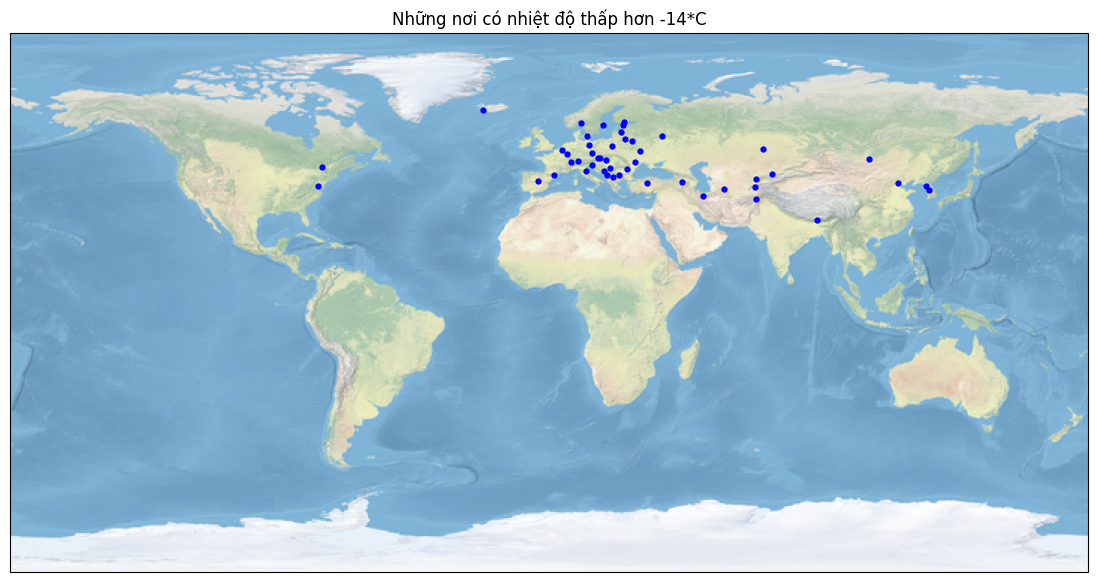

In [44]:
plot_world_map(long_out_low_atemp, lat_out_low_atemp, "Những nơi có nhiệt độ thấp hơn -14*C")

Có thể thấy các vĩ độ của các thành phố có nhiệt độ thấp hơn -14 độ đều ở bán cầu bắc, bao gồm các vùng có nhiệt độ thấp: ôn đới, hàn đới, các vùng ở núi cao.

Trên thực tế, ghi nhận nhiều nơi có nhiệt độ rất thấp.

**KẾT LUẬN: apparent_temperature không bị outlier**

### relativehumidity_2m

In [45]:
min_rh = df.selectExpr("min(relativehumidity_2m)").first()[0]
out_rh = IQR_Outlier(df, 'relativehumidity_2m')
out_rh_lower_limit = out_rh[0]

In [46]:
print("Giá trị tối thiểu của relativehumidity_2m:", min_rh)
print("IQR Outlier lower limit của relativehumidity_2m:", out_rh_lower_limit)

Giá trị tối thiểu của relativehumidity_2m: 1
IQR Outlier lower limit của relativehumidity_2m: 19.5


In [47]:
filtered_df = df.filter(col("relativehumidity_2m") < out_rh[0])
city_out_low_rh = filtered_df.groupBy("City").count()
city_out_low_rh.select("City").show()

+--------------------+
|                City|
+--------------------+
|            Gaborone|
|            Canberra|
|              Ottawa|
|           N’Djamena|
|              Vienna|
|             Yerevan|
|    Andorra la Vella|
|         Ouagadougou|
|               Kabul|
|            Brussels|
|             Algiers|
|La Paz (administr...|
|        Buenos Aires|
|             Yaounde|
|            Brasilia|
|              Tirane|
|               Sofia|
|             Thimphu|
|            Santiago|
|              Bangui|
+--------------------+
only showing top 20 rows



In [55]:
city_out_low_rh_list = city_out_low_rh.select("City").rdd.flatMap(lambda x: x).collect()
filtered_city_df = city_df.filter(city_df["Capital"].isin(city_out_low_rh_list))

lat_out_low_rh = filtered_city_df.select("Latitude").rdd.flatMap(lambda x: x).collect()
long_out_low_rh = filtered_city_df.select("Longitude").rdd.flatMap(lambda x: x).collect()

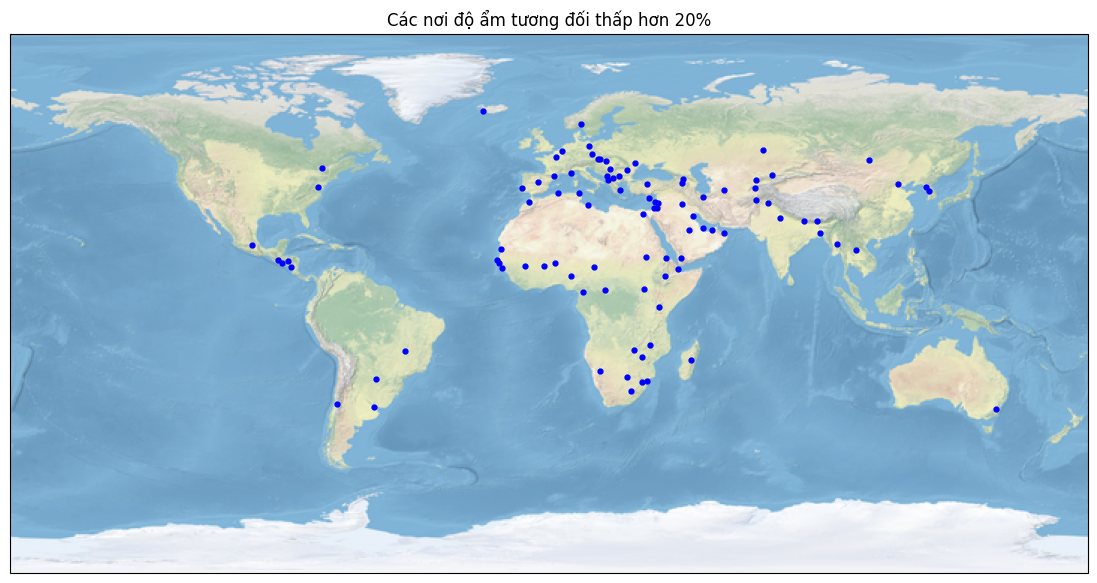

In [56]:
plot_world_map(long_out_low_rh, lat_out_low_rh, name="Các nơi độ ẩm tương đối thấp hơn 20%")

Thực tế, độ ẩm tương đối có thể xuống dưới 20% trong điều kiện khắc nghiệt như sa mạc hoặc vùng khí hậu rất khô (châu Âu, các vùng ôn đới khí hậu đa phần là khô). Một vài nguyên nhân khiến độ ẩm tương đối thấp:

- Mùa đông, độ ẩm thường giảm do lượng nhiệt độ thấp, hơi nước trong không khí giảm.
- Mùa hè khi nhiệt độ tăng mạnh, sự bốc hơi nước nhanh
- Các vùng khí hậu khô hạn như sa mạc
- Ngoài ra có thể do địa hình, chẳng hạn như gió Lào ở Việt Nam

**KẾT LUẬN: Không có giá trị relativehumidity nào bất thường**

### soil_moisture_0_to_7cm

In [57]:
city_soil_moisture_counts = df.filter(col("soil_moisture_0_to_7cm") < 0).groupBy("City").count()
city_soil_moisture_counts.show()

+----------+-----+
|      City|count|
+----------+-----+
|Nouakchott|   65|
+----------+-----+



Theo tìm hiểu: Độ ẩm đất mang giá trị không có nghĩa là độ ẩm thực sự âm. Thay vào đó, giá trị âm thường được sử dụng để chỉ ra rằng đất khô hơn mức cân bằng hoặc mức độ ẩm tối thiểu.

Nouakchott nằm trong những nơi khô cằn nhất trên Trái Đất, là một trong những thành phố lớn nhất tại sa mạc Sahara. Đất ở đây có thể rất khô, và do đó độ ẩm đất có thể cho thấy giá trị âm.

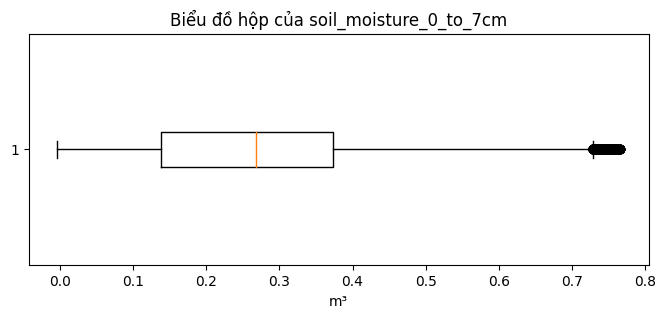

In [58]:
soil_moisture_data = df.select("soil_moisture_0_to_7cm").rdd.flatMap(lambda x: x).collect()

# Vẽ biểu đồ hộp
plt.figure(figsize=(8, 3))
plt.boxplot(soil_moisture_data, vert=False)
plt.xlabel("m³")
plt.title("Biểu đồ hộp của soil_moisture_0_to_7cm")
plt.show()

In [59]:
out_sm07 = IQR_Outlier(df, 'soil_moisture_0_to_7cm')
city_soil_moisture_counts = df.filter(col("soil_moisture_0_to_7cm") > out_sm07[1]).groupBy("City").count()
city_soil_moisture_counts.show()

+--------------------+-----+
|                City|count|
+--------------------+-----+
|Amsterdam; The Ha...|  814|
+--------------------+-----+



Chỉ Amsterdam có giá trị soil_moisture_0_to_7cm cao bất thường.

Tuy nhiên Amsterdam là một thành phố với hệ thống kênh rạch dày đặc, nhiều nước. Vì vậy nên soil_moisture_0_to_7cm cao hơn các nơi khác không có gì lạ

**KẾT LUẬN: soil_moisture_0_to_7cm không có gì bất thường**

### soil_temperature_0_to_7cm
Mặt đất thoát nhiệt chậm hơn so với không khí, vì vậy chỉ cần kiểm tra các giá trị outlier

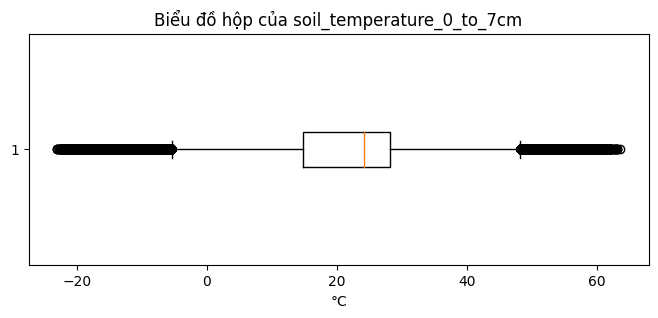

In [60]:
soil_temperature_data = df.select("soil_temperature_0_to_7cm").rdd.flatMap(lambda x: x).collect()

# Vẽ biểu đồ hộp
plt.figure(figsize=(8, 3))
plt.boxplot(soil_temperature_data, vert=False)
plt.xlabel("°C")
plt.title("Biểu đồ hộp của soil_temperature_0_to_7cm")
plt.show()

Nhiệt độ mặt đất trung bình từ dưới -20 độ vẫn có thể xảy ra do nhiệt độ không khí có thể xuống thấp hơn. Mặt đất thường có xu hướng nóng và giữ nhiệt hơn so với bề mặt khí quyển  do mặt đất và khí quyển có khả năng hấp thụ và phản xạ ánh sáng mặt trời khác nhau.

**KẾT LUẬN: Không có soil_temperature_0_to_7cm nào bất thường**

### City
Một số tên chứa cả các mô tả của thành phố

In [61]:
city_df.select("Country", "Capital", "Longitude", "Latitude").show(193)

+--------------------+-------------------+---------+--------+
|             Country|            Capital|Longitude|Latitude|
+--------------------+-------------------+---------+--------+
|         Afghanistan|              Kabul|  69.1725| 34.5289|
|             Albania|             Tirane|  19.8189| 41.3275|
|             Algeria|            Algiers|    3.042| 36.7525|
|             Andorra|   Andorra la Vella|   1.5211| 42.5078|
|              Angola|             Luanda|  13.2343| -8.8368|
| Antigua and Barbuda|       Saint John’s| -61.8457| 17.1172|
|           Argentina|       Buenos Aires| -58.4004|-34.6051|
|             Armenia|            Yerevan|  44.5146|  40.182|
|           Australia|           Canberra| 149.1281|-35.2835|
|             Austria|             Vienna|  16.3707| 48.2064|
|          Azerbaijan|               Baku|   49.892| 40.3777|
|             Bahamas|             Nassau| -77.3431| 25.0582|
|             Bahrain|             Manama|  50.5832| 26.2154|
|       

Có nhiều quốc gia có nhiều thủ đô: thủ đô hành chính, thủ đô lập pháp, thủ đô tư pháp.

Kiểm tra toạ độ trong bảng là của thành phố nào bằng API:
https://api.api-ninjas.com/v1/geocoding?city={city}&country={Nauru}




In [62]:
city_df = city_df.withColumn("index", row_number().over(Window.orderBy(lit(0))))

In [63]:
lst_index_error = [21, 41, 119, 121, 159, 162, 179, 184]
capital = ["La Paz", "Abidjan", "Yaren", "Amsterdam", "Cape Town", "Colombo", "Funafuti", "Dodoma"]

city_df = city_df.withColumn("New_Capital", city_df["Capital"])

for i, idx in enumerate(lst_index_error):
    city_df = city_df.withColumn("New_Capital", when(city_df["index"] == idx, capital[i]).otherwise(city_df["New_Capital"]))

city_df = city_df.drop("Capital").withColumnRenamed("New_Capital", "Capital")

city_df.select("index", "Country", "Capital", "Longitude", "Latitude").show(city_df.count(), truncate=False)

+-----+--------------------------------+-------------------+---------+--------+
|index|Country                         |Capital            |Longitude|Latitude|
+-----+--------------------------------+-------------------+---------+--------+
|1    |Afghanistan                     |Kabul              |69.1725  |34.5289 |
|2    |Albania                         |Tirane             |19.8189  |41.3275 |
|3    |Algeria                         |Algiers            |3.042    |36.7525 |
|4    |Andorra                         |Andorra la Vella   |1.5211   |42.5078 |
|5    |Angola                          |Luanda             |13.2343  |-8.8368 |
|6    |Antigua and Barbuda             |Saint John’s       |-61.8457 |17.1172 |
|7    |Argentina                       |Buenos Aires       |-58.4004 |-34.6051|
|8    |Armenia                         |Yerevan            |44.5146  |40.182  |
|9    |Australia                       |Canberra           |149.1281 |-35.2835|
|10   |Austria                         |

In [64]:
index_col = city_df['index']
other_cols = [col for col in city_df.columns if col != 'index']
city_df = city_df.select(['index'] + other_cols)

**KẾT LUẬN: Trong bước làm sạch, cần thay đổi City ở cả 2 bảng dữ liệu**

### windspeed_10m

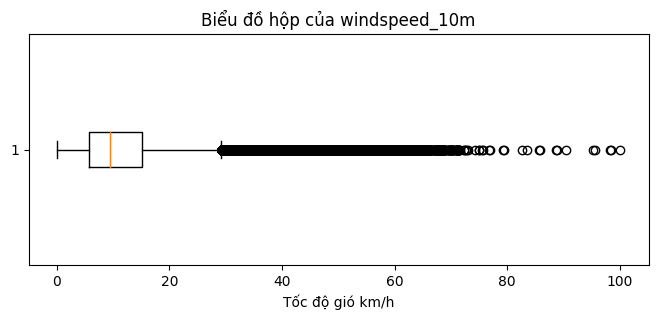

In [65]:
windspeed_10m_data = df.select("windspeed_10m").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(8, 3))
plt.boxplot(windspeed_10m_data, vert=False)
plt.xlabel("Tốc độ gió km/h")
plt.title("Biểu đồ hộp của windspeed_10m")
plt.show()

Vẫn có các cơn gió có tốc độ cao hơn. Mức ~100km/h là gió cấp 10, cấp 11

**KẾT LUẬN: Không có windspeed_10m nào bất thường**

## Logic

### weathercode và cloudcover
Khi **weathercode** = 0 hoặc 1 thì **cloudcover** phải thấp

In [66]:
df_wc0 = df.select('weathercode', 'cloudcover').filter(df.weathercode == 0)
cloudcover_0 = df_wc0.groupBy('cloudcover').agg(count('*').alias('count'))

In [67]:
cloudcover_0_pandas = cloudcover_0.toPandas()

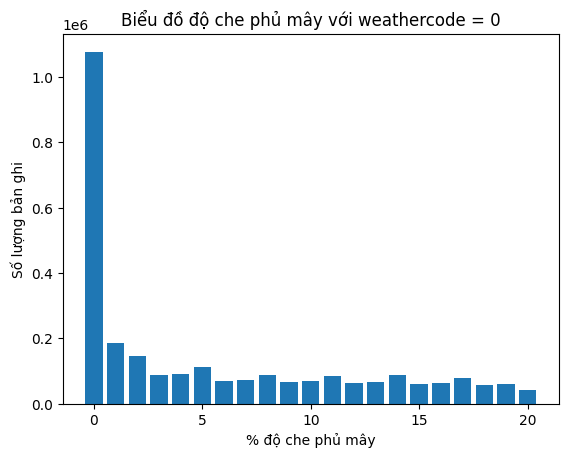

In [68]:
plt.bar(cloudcover_0_pandas['cloudcover'], cloudcover_0_pandas['count'])
plt.xlabel("% độ che phủ mây")
plt.ylabel("Số lượng bản ghi")
plt.title("Biểu đồ độ che phủ mây với weathercode = 0")
plt.show()

In [69]:
# Dữ liệu có weathercode = 1
df_wc1 = df.filter(df.weathercode == 1).select('weathercode', 'cloudcover')
cloudcover_1 = df_wc1.groupBy('cloudcover').agg(count('*').alias('count'))

In [70]:
cloudcover_1_pandas = cloudcover_1.toPandas()

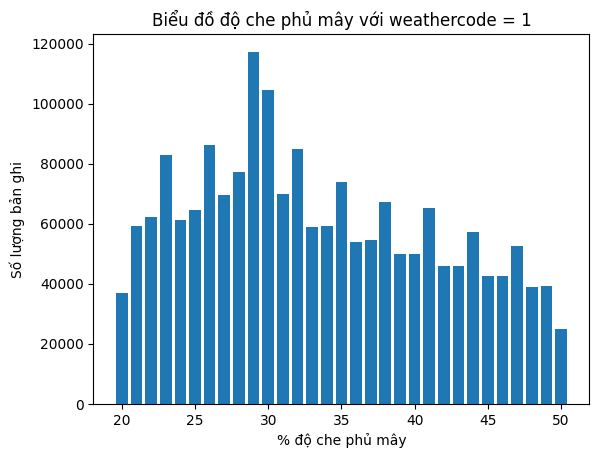

In [71]:
plt.bar(cloudcover_1_pandas['cloudcover'], cloudcover_1_pandas['count'])
plt.xlabel("% độ che phủ mây")
plt.ylabel("Số lượng bản ghi")
plt.title("Biểu đồ độ che phủ mây với weathercode = 1")
plt.show()

Giá trị weathercode = 0 thì cloudcover < 20%

Giá trị weathercode = 1 thì cloudcover >= 20% và < 50%

**Vậy weathercode và cloud không sai về logic**

### precipitation

#### Với weathercode
    + Mã 0: Thời tiết trong lành
    + Mã 1: Mây mỏng hoặc ít mây
    + Mã 2: Mây xám hoặc có mây
    + Mã 3: Mây dày
    + Mã 51: Có mưa
    + Mã 53: Mưa rào
    + Mã 55: Mưa đá
    + Mã 61: Có tuyết
    + Mã 63: Tuyết rơi
    + Mã 71: Có sấm sét
    + Mã 73: Sấm sét và mưa
    + Mã 65: Sấm sét và tuyết
    + Mã 75: Sấm sét và mưa đá

In [72]:
weathercode_counts = weathercode_counts = filtered_df.groupBy('weathercode').agg(count('*').alias('count')).groupBy('weathercode').agg(count('*').alias('count'))
weathercode_keys = weathercode_counts.select('weathercode').rdd.map(lambda row: row[0]).collect()
print(weathercode_keys)

[53, 1, 3, 61, 55, 51, 2, 0, 71]


Tổng lượng nước > 0 khi có mưa (tức từ 51 trở lên)

Tất cả đều là mã thời tiết đúng, không có 0,1,2,3.

**KẾT LUẬN: Không có gì sai trong mối quan hệ precipitation và weathercode**

#### Với rain, snowfall

Theo công thức thì precipitation = rain + snowfall/0.7

In [73]:
df_not_equal = df.select("precipitation", "rain", "snowfall").filter(
    df["precipitation"] != round(df["rain"] + df["snowfall"] / 0.7, 1))


In [87]:
print(df_not_equal.count())

8170


Có 8170 dữ liệu bị tính toán sai!

In [74]:
df_not_equal.show()

+-------------+----+--------+
|precipitation|rain|snowfall|
+-------------+----+--------+
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
|          0.0| 0.0|    0.07|
+-------------+----+--------+
only showing top 20 rows



Sai lệch có thể do cách làm tròn của 2 cột khác nhau .

**KẾT LUẬN: Cần sửa các giá trị precipitation bị tính sai**

### pressure_msl, surface_pressure và elevation
Khi khu vực cao so với mực nước biển thì pressure_msl > surface_pressure và ngược lại

In [75]:
city_pressure_counts = df.filter(df.pressure_msl <= df.surface_pressure).groupBy('City').agg(count('*').alias('count'))

In [76]:
city_pressure_counts.show()

+------------+-----+
|        City|count|
+------------+-----+
|        Baku|40176|
|Tarawa Atoll|40176|
+------------+-----+



In [77]:
filtered_capitals = city_df.filter(city_df.elevation <= 0).select('Capital')
filtered_capitals.show()

+------------+
|     Capital|
+------------+
|        Baku|
|Tarawa Atoll|
+------------+



2 thành phố trên đúng là thấp hơn so với mực nước biển

**KẾT LUẬN: Không sai về logic giữa pressure_msl, surface_pressure và elevation**

### winddirection_10m
Giá trị chỉ trong đoạn 0-359

In [78]:
min_wind_direction = df.selectExpr("min(winddirection_10m) as min_wind_direction").first().min_wind_direction
max_wind_direction = df.selectExpr("max(winddirection_10m) as max_wind_direction").first().max_wind_direction

In [79]:
print("Minimum winddirection_10m:", min_wind_direction)
print("Maximum winddirection_10m:", max_wind_direction)

Minimum winddirection_10m: 0
Maximum winddirection_10m: 360


2 điểm 0 và 360 bị trùng nhau.

**KẾT LUẬN: Cần chuyển các giá trị winddirection_10m = 360 thành 0**


### cloudcover
Cần thuộc đoạn 0-100

In [80]:
min_cloudcover = df.selectExpr("min(cloudcover) as min_cloudcover").first().min_cloudcover
max_cloudcover = df.selectExpr("max(cloudcover) as max_cloudcover").first().max_cloudcover

In [81]:
print("Minimum cloudcover:", min_cloudcover)
print("Maximum cloudcover:", max_cloudcover)

Minimum cloudcover: 0
Maximum cloudcover: 100


**KẾT LUẬN: cloudcover không sai logic**

## Tổng kết các vấn đề

**Có 3 vấn đề cần được làm sạch**

- City cần sửa lại tên và chọn giá trị duy nhất đúng với toạ độ
- Cần chuyển các giá trị winddirection_10m = 360 thành 0
- Cần sửa các giá trị precipitation bị tính sai

# Làm sạch dữ liệu

## precipitation

In [82]:
df = df.withColumn("index", row_number().over(Window.orderBy(lit(0))))

In [83]:
df_2 = df

idx_precipitation_error = df.filter(df['precipitation'] != round(df['rain'] + df['snowfall'] / 0.7, 1)).select("index")

def calculate_precipitation(row):
    return round(row['rain'] + row['snowfall'] / 0.7, 1)

df_2 = df_2.withColumn("precipitation", round(df_2['rain'] + df_2['snowfall'] / 0.7, 1))

df_2.filter(df_2['precipitation'] != round(df_2['rain'] + df_2['snowfall'] / 0.7, 1)).show()


+----+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+----+-----+
|time|temperature_2m|relativehumidity_2m|dewpoint_2m|apparent_temperature|precipitation|rain|snowfall|weathercode|pressure_msl|surface_pressure|cloudcover|windspeed_10m|winddirection_10m|soil_temperature_0_to_7cm|soil_moisture_0_to_7cm|is_day|City|index|
+----+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------+------+----+-----+
+----+--------------+-------------------+-----------+--------------------+-------------+----+--------+-----------+------------+----------------+----------+-------------+-----------------+-------------------------+----------------------

## winddirection_10m

In [84]:
idx_wind_error = df.filter(df['winddirection_10m'] == 360).select("index")
df_2 = df_2.withColumn("winddirection_10m", when(df_2['winddirection_10m'] == 360, 0).otherwise(df_2['winddirection_10m']))

In [85]:
count_wind_error = df_2.filter(df_2['winddirection_10m'] == 360).count()
print(count_wind_error)

0


## City
chuyển ở cả 2 bảng dữ liệu

In [86]:
city_df_copy = city_df
for i, idx in enumerate(lst_index_error):
    city_df_copy = city_df_copy.withColumn("New_Capital", when(city_df_copy["index"] == idx, capital[i]).otherwise(city_df_copy["Capital"]))

city_df_copy = city_df_copy.drop("Capital").withColumnRenamed("New_Capital", "Capital")
df_2 = df_2.withColumn("City", when(df_2["index"].isin(lst_index_error), capital[i]).otherwise(df_2["City"]))
city_df_copy = city_df_copy.select("index", "Country", "Capital", "Longitude", "Latitude")

# Lưu dữ liệu sau khi làm sạch

In [ ]:
df_2.to_csv(path+"data_cleaned.csv", index=False)

In [ ]:
city_df_copy.to_csv(path+"country_city_cleaned.csv", index=False)